# Webscraping Weather Data

## STEP 1: Webscraping using Requests and BeautifulSoup

In [1]:
import requests
import bs4
# from IPython.core.display import display, HTML

res = requests.get("https://ims.data.gov.il/sites/default/files/IMS_001.xml")
# display(HTML(res.text))

In [2]:
soup = bs4.BeautifulSoup(res.text,'lxml')

Inspect the retrieved html

In [ ]:
soup

## STEP 2: Create a Pandas DataFrame, fill and manipulate it

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
import datetime as dt

%matplotlib inline

In [5]:
df = pd.DataFrame()

times = []
locations = []
temperature = []
windspeed = []
humidity = []
wind_direction = []

for time in soup.select('forecasttime'):
    times.append(time.text)
for location in soup.select('locationname'):
    locations.append(location.text)
for temp in soup.select('temperature'):
    temperature.append(temp.text)
for wind in soup.select('windspeed'):
    windspeed.append(wind.text)
for humid in soup.select('relativehumidity'):
    humidity.append(humid.text)
for direction in soup.select('winddirection'):
    wind_direction.append(direction.text)

df['time'] = pd.to_datetime(times) # Convert to datetime
df['locations'] = sorted(locations * 79) # Multiply each location 79 times to create 790 instances.
df['temperature'] = pd.to_numeric(temperature)
df['windspeed'] = pd.to_numeric(windspeed)
df['humidity'] = pd.to_numeric(humidity)
df['wind degrees'] = pd.to_numeric(wind_direction)
df['wind radians'] = df['wind degrees'] *np.pi/180
df['hour'] = df['time'].dt.hour

In [6]:
df['locations'].unique()

array(['AFULA NIR HAEMEQ', 'ASHQELON PORT', 'AVDAT', 'BEER SHEVA',
       'EDEN FARM', 'ESHHAR', 'HAKFAR HAYAROK', 'JERUSALEM CENTRE',
       'LOD 12 IAA (LLBG)', 'ZEFAT HAR KENAAN'], dtype=object)

In [7]:
regions = {'AFULA NIR HAEMEQ':'North','EDEN FARM':'North','ESHHAR':'North','ZEFAT HAR KENAAN':'North',
     'HAKFAR HAYAROK':'Central','JERUSALEM CENTRE':'Central','LOD 12 IAA (LLBG)':'Central',
     'ASHQELON PORT':'South','AVDAT':'South','BEER SHEVA':'South'}

df['regions'] = df['locations'].map(regions)

In [8]:
def wind_compass(direction):

    if 45 <= direction < 135:
        return 'east'
    if 135 <= direction < 225:
        return 'south'
    if 225 <= direction < 315:
        return 'west'
    else:
        return 'north'

In [9]:
df['wind direction'] = df['wind degrees'].apply(wind_compass)

In [10]:
df.head()

,time,locations,temperature,windspeed,humidity,wind degrees,wind radians,hour,regions,wind direction
0,2020-10-22 19:00:00+00:00,AFULA NIR HAEMEQ,23.0,2.3,64,307,5.358161,19,North,west
1,2020-10-22 20:00:00+00:00,AFULA NIR HAEMEQ,22.1,2.2,68,321,5.602507,20,North,north
2,2020-10-22 21:00:00+00:00,AFULA NIR HAEMEQ,21.8,2.4,67,315,5.497787,21,North,north
3,2020-10-22 22:00:00+00:00,AFULA NIR HAEMEQ,21.5,1.8,66,309,5.393067,22,North,west
4,2020-10-22 23:00:00+00:00,AFULA NIR HAEMEQ,21.9,1.2,62,315,5.497787,23,North,north


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   time            790 non-null    datetime64[ns, UTC]
 1   locations       790 non-null    object             
 2   temperature     790 non-null    float64            
 3   windspeed       790 non-null    float64            
 4   humidity        790 non-null    int64              
 5   wind degrees    790 non-null    int64              
 6   wind radians    790 non-null    float64            
 7   hour            790 non-null    int64              
 8   regions         790 non-null    object             
 9   wind direction  790 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(3), int64(3), object(3)
memory usage: 61.8+ KB


In [12]:
df.describe()

,temperature,windspeed,humidity,wind degrees,wind radians,hour
count,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000
mean,24.474937,2.481899,47.646835,167.506329,2.923537,11.822785
std,3.983779,1.398909,29.449242,102.673227,1.791986,7.248547
min,17.700000,0.100000,8.000000,0.000000,0.000000,0.000000
25%,21.500000,1.400000,18.000000,88.000000,1.535890,5.000000
50%,23.550000,2.300000,45.000000,132.000000,2.303835,12.000000
75%,26.900000,3.400000,77.000000,276.500000,4.825835,19.000000
max,37.200000,6.300000,99.000000,359.000000,6.265732,23.000000


## STEP 3: Plot visuals using the DataFrame with Seaborn

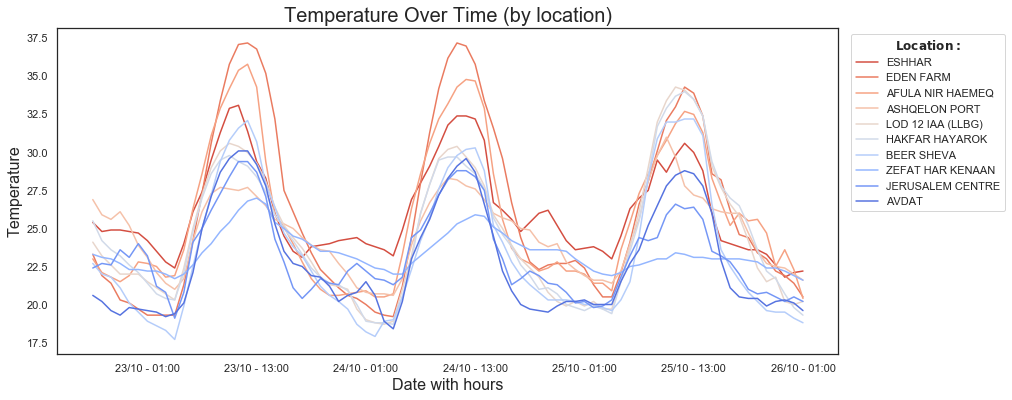

In [13]:
sns.set_theme(style="white")
plt.figure(figsize=(14,6))

g = sns.lineplot(data=df, x='time', y='temperature', hue='locations', palette='coolwarm_r',
             hue_order=df.groupby('locations')['temperature'].mean().sort_values(ascending=False).index)

plt.legend(bbox_to_anchor=(0,0,1.22,1), title=r'$\bf{Location:}$')

g.xaxis.set_major_locator(md.HourLocator(interval = 12))
g.xaxis.set_major_formatter(md.DateFormatter('%d/%m - %H:%M'))
g.set_xlabel('Date with hours', fontsize=16), g.set_ylabel('Temperature', fontsize=16), g.set_title('Temperature Over Time (by location)', fontsize=20)

plt.savefig(fname='temp.png', bbox_inches='tight')

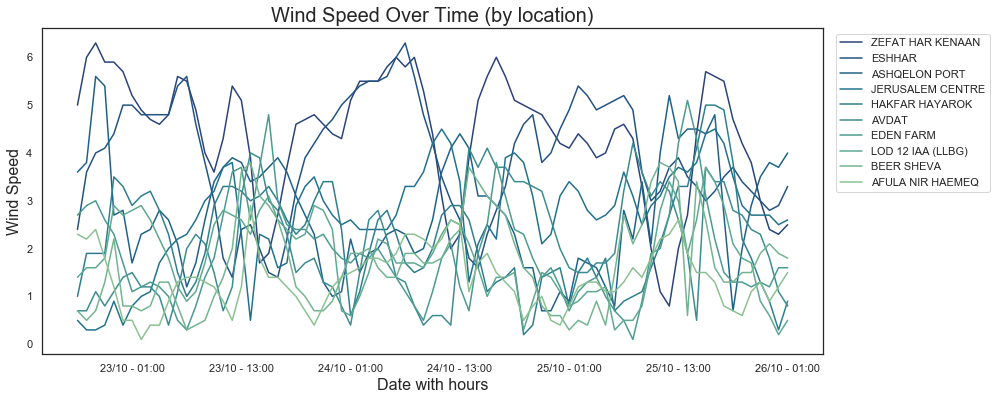

In [14]:
sns.set_theme(style="white")
plt.figure(figsize=(14,6))

g = sns.lineplot(data=df, x='time', y='windspeed', hue='locations', palette='crest_r',
             hue_order=df.groupby('locations')['windspeed'].mean().sort_values(ascending=False).index)

plt.legend(bbox_to_anchor=(0,0,1.22,1))

g.xaxis.set_major_locator(md.HourLocator(interval = 12))
g.xaxis.set_major_formatter(md.DateFormatter('%d/%m - %H:%M'))
g.set_xlabel('Date with hours', fontsize=16), g.set_ylabel('Wind Speed', fontsize=16), g.set_title('Wind Speed Over Time (by location)', fontsize=20)

plt.savefig(fname='windspeed.png', bbox_inches='tight')

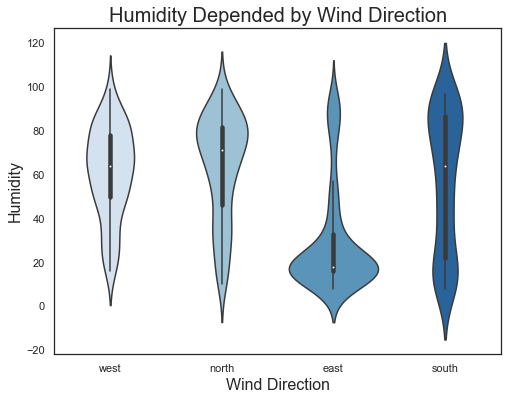

In [15]:
sns.set_theme(style="white")
plt.figure(figsize=(8,6))

sns.violinplot(data=df, x='wind direction', y='humidity', palette='Blues')

plt.xlabel('Wind Direction', fontsize=16), plt.ylabel('Humidity', fontsize=16), plt.title('Humidity Depended by Wind Direction', fontsize=20)

plt.savefig(fname='violin.png', bbox_inches='tight')

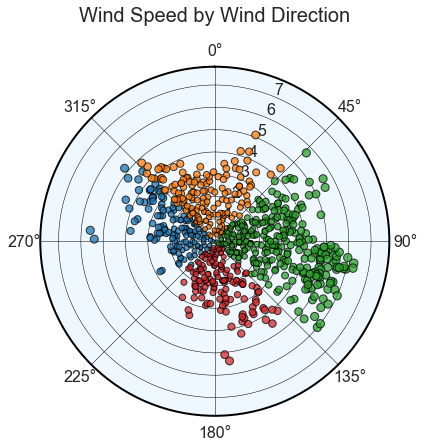

In [16]:
sns.set_theme(style='darkgrid', rc={'axes.linewidth':2, 'axes.edgecolor':'black', 'grid.linewidth':0.5, 'grid.color':'black',
                                    'axes.facecolor':'aliceblue', 'figure.facecolor':'white'})

g = sns.FacetGrid(data=df, hue='wind direction', palette='tab10', subplot_kws=dict(projection='polar'), height=6, despine=False)
g.map(sns.scatterplot, 'wind radians', 'windspeed', linewidth=1, edgecolor='black', alpha=0.75, size=df['windspeed']*10)
g.set_ylabels(""), g.set_xlabels("")
plt.title('Wind Speed by Wind Direction\n', fontsize=20)
plt.gca().tick_params(labelsize=16)
plt.gca().set_theta_zero_location("N")
plt.gca().set_theta_direction(-1)

plt.savefig(fname='compass.png', bbox_inches='tight')

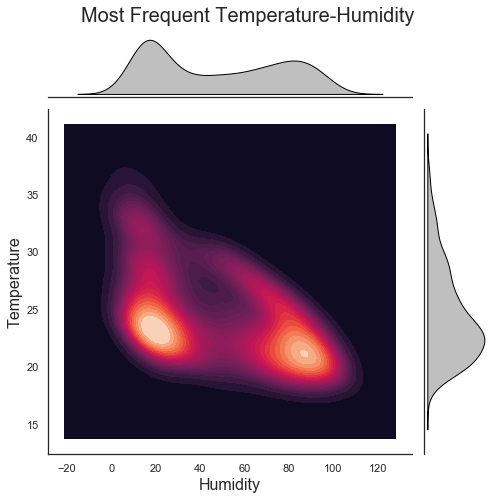

In [17]:
sns.set_theme(style="white")

g = sns.JointGrid(data=df, x='humidity', y='temperature', height=7)

g.plot_joint(sns.kdeplot, fill=True, thresh=0, levels=25, cmap="rocket")
g.plot_marginals(sns.kdeplot, fill=True, color='black')
g.set_axis_labels(xlabel='Humidity', ylabel='Temperature', fontsize=16)

g.fig.suptitle('Most Frequent Temperature-Humidity', fontsize=20), g.fig.subplots_adjust(top=0.92)

plt.savefig(fname='rocket.png', bbox_inches='tight')

### Some more visuals

In [ ]:
sns.set_theme(style='darkgrid', rc={'axes.linewidth':1, 'axes.edgecolor':'black'})

In [ ]:
sns.boxplot(data=df, x='windspeed', y='locations', palette='Blues')

In [ ]:
sns.boxplot(data=df, x='regions', y='windspeed', palette='Blues')

In [ ]:
sns.boxplot(data=df, x='temperature', y='locations', palette='coolwarm_r')

In [ ]:
sns.boxplot(data=df, x='regions', y='temperature', palette='icefire', order=['North','Central','South'])

In [ ]:
sns.boxplot(data=df, x='humidity', y='locations', palette='Blues')

In [ ]:
sns.boxplot(data=df, x='regions', y='humidity', palette='Blues')

In [ ]:
sns.violinplot(data=df, x='wind direction', y='windspeed', palette='Blues')

In [ ]:
sns.boxplot(data=df, x='wind direction', y='humidity', palette='Blues')
sns.stripplot(data=df, x='wind direction', y='humidity', palette='Blues', edgecolor='black', linewidth=1, alpha=0.5)

In [ ]:
sns.catplot(data=df, x='hour', y='temperature', col='regions', kind='box', color='b')

In [ ]:
sns.set_style('white'), plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='time', y='temperature', hue='regions')
plt.legend(bbox_to_anchor=(0,0,1,1))

In [ ]:
sns.set_theme(style="white")

g = sns.JointGrid(data=df, x='temperature', y='windspeed',height=7)

g.plot_joint(sns.kdeplot, fill=True, thresh=0, levels=25, cmap="viridis")
g.plot_marginals(sns.kdeplot, fill=True, color='b')

## STEP 4: Connect to mail using smtplib, create message container using MIME

Adding graphs to mail:

In [ ]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
import getpass

# Provide the currect details (make sure you have the app password for you email):
Email = input("Enter your email: ")
Password = getpass.getpass("Enter your app password: ")
Address = input("Send mail to: ")

# Create the message container:
msg = MIMEMultipart('alternative')
msg['Subject'] = "Today's Weather Report!"
msg['From'] = Email
msg['To'] = Address
msg.preamble = 'This is a multi-part message in MIME format.' # Shown only in case email don't support MIME format.

# Creating the plain text (alternative message) and the html format.
# (HTML only is more likley to get filtered/rarely not supported by some email providers/some users disable html).
text = 'This is the alternative plain text message (not html).'
html = """\
<html>
  <head><b>Today's Weather Report!</b></head>
  <body>
    <p>The report is based on data from IMS (Israel Meteorological Service) - <a href="https://ims.gov.il/">link</a><br><br><br>
       <br><img src="cid:image1"><br><br>
       <br><img src="cid:image2"><br><br>
       <br><img src="cid:image3"><br><br>
       <br><img src="cid:image4"><br><br>
       <br><img src="cid:image5"><br><br><br>
       <br><i>This message was created with Python 3.8 including the libraries: pandas, numpy, matplotlib, seaborn, requests, beautifulsoup4, smtplib, MIME and a few more.<br>
       <br><b>The project was created by Roei Arpaly</b>
    </p>
  </body>
</html>
"""

text_part = MIMEText(text, 'plain')
html_part = MIMEText(html, 'html')

msg.attach(text_part)
msg.attach(html_part)

# Add the pictures by the wanted order:
pictures = ['temp.png','windspeed.png','violin.png','compass.png','rocket.png']
for i in range(len(pictures)):
    image = open(pictures[i], 'rb')
    msgImage = MIMEImage(image.read())
    image.close()
    msgImage.add_header('Content-ID', f'<image{i+1}>') # As attached files: msgImage.add_header('Content-Disposition', 'attachment', filename=pictures[i])
    msg.attach(msgImage)

# Connect to the email using smtplib.
smtp = smtplib.SMTP('smtp.gmail.com',587)
smtp.ehlo()
smtp.starttls()
smtp.login(Email, Password)
smtp.sendmail(Email, Address, msg.as_string())
smtp.quit()

## STEP 5: Process automation (optional)

In [ ]:
import requests
import bs4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
import datetime as dt
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
import getpass
import time
from random import randint


regions = {'AFULA NIR HAEMEQ':'North','EDEN FARM':'North','ESHHAR':'North','ZEFAT HAR KENAAN':'North',
    'HAKFAR HAYAROK':'Central','JERUSALEM CENTRE':'Central','LOD 12 IAA (LLBG)':'Central',
    'ASHQELON PORT':'South','AVDAT':'South','BEER SHEVA':'South'}

def wind_compass(direction):

    if 45 <= direction < 135:
        return 'east'
    if 135 <= direction < 225:
        return 'south'
    if 225 <= direction < 315:
        return 'west'
    else:
        return 'north'


# Provide the currect details for smtplib (make sure you have the app password for you email):
Email = input("Enter your email: ")
Password = getpass.getpass("Enter your app password: ")
Address = input("Send mail to: ")


# Process automation:

# Choose number of repeations
end_after = 10
repeation = 0

while repeation < end_after:
  
    # Webscraping using Requests and BeautifulSoup
    res = requests.get("https://ims.data.gov.il/sites/default/files/IMS_001.xml")
    soup = bs4.BeautifulSoup(res.text,'lxml')

    # Create a Pandas DataFrame, fill and manipulate it
    df = pd.DataFrame()

    times, locations, temperature, windspeed, humidity, wind_direction = [],[],[],[],[],[]
    columns = [times, locations, temperature, windspeed, humidity, wind_direction]
    scrapelist = ['forecasttime','locationname','temperature','windspeed','relativehumidity','winddirection']

    for i in range(len(columns)):
        for item in soup.select(scrapelist[i]):
            columns[i].append(item.text)

    df['time'] = pd.to_datetime(times) # Convert to datetime
    df['locations'] = sorted(locations * 79) # Multiply each location 79 times to create 790 instances.
    df['temperature'] = pd.to_numeric(temperature)
    df['windspeed'] = pd.to_numeric(windspeed)
    df['humidity'] = pd.to_numeric(humidity)
    df['wind degrees'] = pd.to_numeric(wind_direction)
    df['wind radians'] = df['wind degrees'] *np.pi/180
    df['hour'] = df['time'].dt.hour
    df['regions'] = df['locations'].map(regions)
    df['wind direction'] = df['wind degrees'].apply(wind_compass)

    # Plot visuals using the DataFrame with Seaborn
    # Image 1
    sns.set_theme(style="white"), plt.figure(figsize=(14,6))
    g = sns.lineplot(data=df, x='time', y='temperature', hue='locations', palette='coolwarm_r',
              hue_order=df.groupby('locations')['temperature'].mean().sort_values(ascending=False).index)
    plt.legend(bbox_to_anchor=(0,0,1.22,1), title=r'$\bf{Location:}$')
    g.xaxis.set_major_locator(md.HourLocator(interval = 12)), g.xaxis.set_major_formatter(md.DateFormatter('%d/%m - %H:%M'))
    g.set_xlabel('Date with hours', fontsize=16), g.set_ylabel('Temperature', fontsize=16), g.set_title('Temperature Over Time (by location)', fontsize=20)
    plt.savefig(fname='temp.png', bbox_inches='tight')

    # Image 2
    sns.set_theme(style="white"), plt.figure(figsize=(14,6))
    g = sns.lineplot(data=df, x='time', y='windspeed', hue='locations', palette='crest_r',
              hue_order=df.groupby('locations')['windspeed'].mean().sort_values(ascending=False).index)
    plt.legend(bbox_to_anchor=(0,0,1.22,1))
    g.xaxis.set_major_locator(md.HourLocator(interval = 12)), g.xaxis.set_major_formatter(md.DateFormatter('%d/%m - %H:%M'))
    g.set_xlabel('Date with hours', fontsize=16), g.set_ylabel('Wind Speed', fontsize=16), g.set_title('Wind Speed Over Time (by location)', fontsize=20)
    plt.savefig(fname='windspeed.png', bbox_inches='tight')

    # Image 3
    sns.set_theme(style="white"), plt.figure(figsize=(8,6))
    sns.violinplot(data=df, x='wind direction', y='humidity', palette='Blues')
    plt.xlabel('Wind Direction', fontsize=16), plt.ylabel('Humidity', fontsize=16), plt.title('Humidity Depended by Wind Direction', fontsize=20)
    plt.savefig(fname='violin.png', bbox_inches='tight')

    # Image 4
    sns.set_theme(style='darkgrid', rc={'axes.linewidth':2, 'axes.edgecolor':'black', 'grid.linewidth':0.5, 'grid.color':'black',
                                      'axes.facecolor':'aliceblue', 'figure.facecolor':'white'})
    g = sns.FacetGrid(data=df, hue='wind direction', palette='tab10', subplot_kws=dict(projection='polar'), height=6, despine=False)
    g.map(sns.scatterplot, 'wind radians', 'windspeed', linewidth=1, edgecolor='black', alpha=0.75, size=df['windspeed']*10)
    plt.gca().set_theta_zero_location("N"), plt.gca().set_theta_direction(-1), plt.gca().tick_params(labelsize=16)
    plt.title('Wind Speed by Wind Direction\n', fontsize=20), g.set_ylabels(""), g.set_xlabels("")
    plt.savefig(fname='compass.png', bbox_inches='tight')

    # Image 5
    sns.set_theme(style="white")
    g = sns.JointGrid(data=df, x='humidity', y='temperature', height=7)
    g.plot_joint(sns.kdeplot, fill=True, thresh=0, levels=25, cmap="rocket")
    g.plot_marginals(sns.kdeplot, fill=True, color='black')
    g.set_axis_labels(xlabel='Humidity', ylabel='Temperature', fontsize=16)
    g.fig.suptitle('Most Frequent Temperature-Humidity', fontsize=20), g.fig.subplots_adjust(top=0.92)
    plt.savefig(fname='rocket.png', bbox_inches='tight')

    # Create the message container:
    msg = MIMEMultipart('alternative')
    msg['Subject'] = "Today's Weather Report!"
    msg['From'] = Email
    msg['To'] = Address
    msg.preamble = 'This is a multi-part message in MIME format.' # Shown only in case email don't support MIME format.

    # Creating the plain text (alternative message) and the html format.
    # (HTML only is more likley to get filtered/rarely not supported by some email providers/some users disable html).
    text = 'This is the alternative plain text message (not html).'
    html = """\
    <html>
    <head><b>Today's Weather Report!</b></head>
    <body>
      <p>The report is based on data from IMS (Israel Meteorological Service) - <a href="https://ims.gov.il/">link</a><br><br><br>
        <br><img src="cid:image1"><br><br>
        <br><img src="cid:image2"><br><br>
        <br><img src="cid:image3"><br><br>
        <br><img src="cid:image4"><br><br>
        <br><img src="cid:image5"><br><br><br>
        <br><i>This message was created with Python 3.8 including the libraries: pandas, numpy, matplotlib, seaborn, requests, beautifulsoup4, smtplib, MIME and a few more.<br>
        <br><b>The project was created by Roei Arpaly</b>
      </p>
    </body>
    </html>
    """

    text_part = MIMEText(text, 'plain')
    html_part = MIMEText(html, 'html')

    msg.attach(text_part)
    msg.attach(html_part)

    # Add the pictures by the wanted order:
    pictures = ['temp.png','windspeed.png','violin.png','compass.png','rocket.png']
    for i in range(len(pictures)):
        image = open(pictures[i], 'rb')
        msgImage = MIMEImage(image.read())
        image.close()
        msgImage.add_header('Content-ID', f'<image{i+1}>') # As attached files: msgImage.add_header('Content-Disposition', 'attachment', filename=pictures[i])
        msg.attach(msgImage)

    # Connect to the email using smtplib.
    smtp = smtplib.SMTP('smtp.gmail.com',587)
    smtp.ehlo()
    smtp.starttls()
    smtp.login(Email, Password)
    smtp.sendmail(Email, Address, msg.as_string())
    smtp.quit()
    
    repeation += 1
    print(f'The mail has been sent successfuly to {Address} at the {repeation} time!')
    
    # Choose how long to wait between each process, (it is not recommended to webscrape at a fixed interval).
    hours = 6
    seconds = randint(3600*(hours-1),3600*(hours+1))
    time.sleep(seconds)